#Cleaning and organizing data

In [430]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

##Uploading data
###Text data from Justia
To begin, we upload our main data source: syllabi of Supreme Court cases. A syllabus is the official summary of a Supreme Court decision, and is published by the Supreme Court together with the justices' opinions. Our sample is all Supreme Court cases since 1946. This is about 11,000 cases (an enormous amount of text), so we randomly sample 10% of these cases to make the problem more tractable. 

In [431]:
#Read to a dataframe the CSV of opinions (really, these are syllabi, not opinions)
opinion_df = pd.read_csv("justia_data_clean - justia_data_clean.csv")
opinion_df.head()

,year,case,citation,text
0,1946,Eagles v. Samuels,Eagles v. Samuels 329 U.S. 304 (1946),"Eagles v. Samuels No. 59 Argued November 21, 1..."
1,1946,Eagles v. Horowitz,Eagles v. Horowitz 329 U.S. 317 (1946),"Eagles v. Horowitz No. 58 Argued November 21, ..."
2,1946,Labor Board v. A. J. Tower Co.,Labor Board v. A. J. Tower Co. 329 U.S. 324 (1...,Labor Board v. A. J. Tower Co. No. 60 Argued N...
3,1946,Gibson v. United States,Gibson v. United States 329 U.S. 338 (1946),Gibson v. United States No. 23 Argued January ...
4,1946,Illinois v. Campbell,Illinois v. Campbell 329 U.S. 362 (1946),Illinois ex rel. Gordon v. Campbell No. 35 Arg...


In [433]:
from random import sample
print "total number of cases: ", len(opinion_df)

#Randomly sample to get 20% of the cases 
sample_df = opinion_df.loc[sample(opinion_df.index, len(opinion_df)/5)]
#Reset index 
sample_df = sample_df.reset_index(drop=True)
#create a unique case_id for each case
sample_df['case_id'] = sample_df.index

number of cases:  11221


5th percentile:  124.0
25th percentile:  933.5
50th percentile:  2570.0
75th percentile:  4976.25
95th percentile:  7639.0


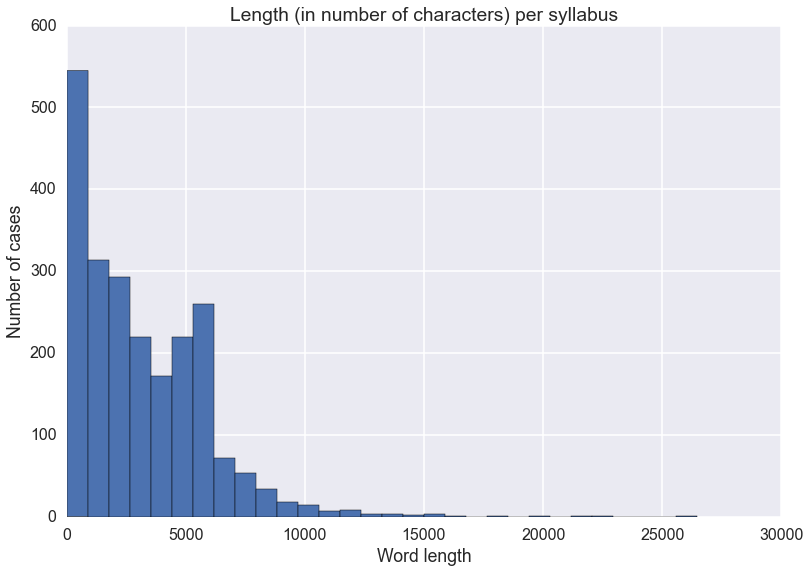

In [434]:
#get length of syllabi to determine which syllabi are undecided cases (ie, very short syllabi)
hist_textlength =[]
textlength = []
for index, row in sample_df.iterrows():
    l = len(str(row['text']))
    textlength.append((l,row['case_id']))
    hist_textlength.append(l)
plt.hist(hist_textlength,bins=30)
plt.title("Length (in number of characters) per syllabus")
plt.ylabel("Number of cases")
plt.xlabel("Word length")
#print percentiles: 
p5 = np.percentile(hist_textlength, 5) #5th percentile
p25 = np.percentile(hist_textlength, 25) #5th percentile
p50 = np.percentile(hist_textlength, 50) #5th percentile
p75 = np.percentile(hist_textlength, 75) #5th percentile
p95 = np.percentile(hist_textlength, 95) #5th percentile
print "5th percentile: ", p5
print "25th percentile: ", p25
print "50th percentile: ", p50
print "75th percentile: ", p75
print "95th percentile: ", p95

We see that there are a lot of syllabi with very few characters. This is because there are a number of syllabi of cases that were not actually decided; the syllabus simply consists of the case name and nothing more. We want to remove these cases from our dataset. In the following cell, we figure out what the appropriate cutoff length is by looking at cases with different numbers of characters (a proxy for number of words) by looking at syllabi with various numbers of characters.

In [435]:
#function to find the text length closest to a given length 
closest = lambda num: min(hist_textlength, key=lambda x:abs(x-num))
textlength_dict = dict(textlength)
#Here, we find the case id corresponding to the closest number, and print the corresponding text
print "200 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(200)]].iloc[0]['text'] + '\n' #200 characters
print "300 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(300)]].iloc[0]['text'] + '\n' #300 characters
print "400 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(400)]].iloc[0]['text'] + '\n' #400 characters
print "500 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(500)]].iloc[0]['text'] + '\n' #500 characters
print "560 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(560)]].iloc[0]['text'] + '\n' #500 characters
print "600 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(600)]].iloc[0]['text'] + '\n' #600 characters
print "650 characters: "
print sample_df[sample_df['case_id']==textlength_dict[closest(700)]].iloc[0]['text'] + '\n' #650 characters

200 characters: 
 UNITED STATES v. DIAMOND, ALIAS DUMANUS, THORNSON AND SLATER, ET AL.  ON PETITION FOR WRIT OF CERTIORARI TO THE UNITED STATES COURT OF APPEALS  FOR THE NINTH CIRCUIT. No. 771. Decided April 7, 1958. 

300 characters: 
 SCHIPANI v. UNITED STATES.  ON PETITION FOR REHEARING.  No. 504. Certiorari denied, November 7, 1966. Petition for rehearing granted, December 12, 1966.  Certiorari granted; 362 F.2d 825, vacated and remanded.  Jacob P. Lefkowitz for petitioner.  Solicitor General Marshall for the United States.     

400 characters: 
 393 U.S. 1077   UNITED STATES, appellant, v. INTERSTATE COMMERCE COMMISSION et al.   .no. 899.   Charles E. BRUNDAGE et al., appellants, v. UNITED STATES et al.No. 942.   CITY OF AUBURN, appellant, v. UNITED STATES et al.No. 999.   LIVING TON ANTI-MERGER COMMITTEE, appellant, v. INTERSTATE COMMERCE COMMISSION et al.No. 1003.   Supreme Court of the United States   February 24, 1969 

500 characters: 
Cole v. Texas No. A-704 Decided March 1

There is no clear cutoff point based on this ad-hoc analysis. As a somewhat arbitrary solution, we eliminate all cases with text of fewer than 400 characters. (such cases seem unlikley to contain meaningful text, and we note that, for example, the 600-character case does have relevant information in that it references the precedent Zittman v. McGrath).

In [436]:
#Drop cases with fewer than 400 characters
for case in textlength:
    if case[0]<400: 
        sample_df = sample_df[sample_df['case_id']!=case[1]]      
sample_df = sample_df.reset_index(drop=True)

###Supreme Court Database data
Our second data source is the Supreme Court Database (SCDB), which contains data on the issue areas of cases. We upload this data here.

In [437]:
#convert CSV to dataframe, keep useful columns
scdb_df = pd.read_csv("SCDB_2015_01_caseCentered_Citation.csv")
scdb_df = scdb_df[['caseId','docketId','usCite','docket','caseName','dateArgument','issueArea','decisionDirection','majOpinWriter','majVotes','minVotes']]

In [438]:
##sample_df.head()

,year,case,citation,text,case_id
0,1973,Camp v. Pitts,Camp v. Pitts 411 U.S. 138 (1973),"Camp v. Pitts No. 72-864 Decided March 26, 197...",0
1,2005,Johnson v. United States,Johnson v. United States 544 U.S. 295 (2005),JOHNSON v. UNITED STATES certiorari to the uni...,2
2,1968,Peoria Tribe of Indians v. United States,Peoria Tribe of Indians v. United States 390 U...,Peoria Tribe of Indians v. United States No. 2...,3
3,1951,Western Maryland R. Co. v. Rogan,Western Maryland R. Co. v. Rogan 340 U.S. 520 ...,Western Maryland R. Co. v. Rogan No. 205 Argue...,4
4,1947,Bethlehem Steel Co. v. State Labor Relations B...,Bethlehem Steel Co. v. State Labor Relations B...,Bethlehem Steel Co. v. New York State Labor Re...,5


In [413]:
##scdb_df.head()

,caseId,docketId,usCite,docket,caseName,dateArgument,issueArea,decisionDirection,majOpinWriter,majVotes,minVotes
0,1946-001,1946-001-01,329 U.S. 1,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,1/9/1946,8,2,78,8,1
1,1946-002,1946-002-01,329 U.S. 14,12,CLEVELAND v. UNITED STATES,10/10/1945,1,1,81,6,3
2,1946-003,1946-003-01,329 U.S. 29,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,11/8/1945,8,2,84,5,4
3,1946-004,1946-004-01,329 U.S. 40,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,1/31/1946,2,2,87,5,3
4,1946-005,1946-005-01,329 U.S. 64,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",10/25/1946,8,2,78,6,3


In [428]:
#Matching data 
#First, try to match by usCite

#If no match: try matching by name
##sample_df = pd.concat([sample_df,pd.DataFrame(list(scdb_df.columns))],axis=0)

In [441]:
##pd.concat([sample_df,pd.DataFrame(list(scdb_df.columns))])

,0,case,case_id,citation,text,year
0,NaN,Camp v. Pitts,0,Camp v. Pitts 411 U.S. 138 (1973),"Camp v. Pitts No. 72-864 Decided March 26, 197...",1973
1,NaN,Johnson v. United States,2,Johnson v. United States 544 U.S. 295 (2005),JOHNSON v. UNITED STATES certiorari to the uni...,2005
2,NaN,Peoria Tribe of Indians v. United States,3,Peoria Tribe of Indians v. United States 390 U...,Peoria Tribe of Indians v. United States No. 2...,1968
3,NaN,Western Maryland R. Co. v. Rogan,4,Western Maryland R. Co. v. Rogan 340 U.S. 520 ...,Western Maryland R. Co. v. Rogan No. 205 Argue...,1951
4,NaN,Bethlehem Steel Co. v. State Labor Relations B...,5,Bethlehem Steel Co. v. State Labor Relations B...,Bethlehem Steel Co. v. New York State Labor Re...,1947
5,NaN,California v. Texas,6,California v. Texas 457 U.S. 164 (1982),"California v. Texas No. 88, Orig. Decided June...",1982
6,NaN,Huddleston v. United States,7,Huddleston v. United States 485 U.S. 681 (1988),Huddleston v. United States No. 87-6. Argued M...,1988
7,NaN,Powell v. Nevada,8,Powell v. Nevada 511 U.S. 79 (1994),"OCTOBER TERM, 1993 Syllabus POWELL v. NEVADA C...",1994
8,NaN,United States v. Florida,9,United States v. Florida 363 U.S. 121 (1960),"United States v. Florida No. 10, Original Argu...",1960
9,NaN,Sawyer v. Whitley,10,Sawyer v. Whitley 505 U.S. 333 (1992),"OCTOBER TERM, 1991 Syllabus SAWYER v. WHITLEY,...",1992


##Cleaning text

The below function takes an opinion (a string), and returns the verbs, nouns, adjectives, foreign words, and court precedents cited in the opinion. 

In [394]:
import re 
regex1 = r"\(.\)" 

In [395]:
from pattern.en import parse
from pattern.en import pprint
from pattern.en import conjugate, lemma, lexeme
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text

#stopwords and punctuation
stopwords=text.ENGLISH_STOP_WORDS
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def get_parts(opinion):
    oplow = opinion.lower()
    #REMOVING CHARACTERS: we have ugly text, and remove unnecssary characters.
    oplow = unicode(oplow, 'ascii', 'ignore') #remove non-unicode characters 
    oplow = str(oplow).translate(string.maketrans("\n\t\r", "   ")) #remove characters like \n 
    #justices (eg, Justice Breyer) are referred to as J. (eg,Breyer, J.); we remove the J., also JJ. for plural
    oplow = oplow.replace('j.','')
    oplow = oplow.replace('jj.','')
    oplow = oplow.replace('c.','') #remove C. for chief justice 
    oplow = oplow.replace('pp.','') #page numbers
    oplow = oplow.replace('  ','') #multiple spaces
    oplow = ''.join([i for i in oplow if not i.isdigit()]) #remove digits 
    oplow=re.sub(regex1, ' ', oplow)
    #Remove the Justia disclaimer at the end of the case, if it appears in the string
    justiadisclaimer = "disclaimer: official"
    if justiadisclaimer in oplow: 
        optouse = oplow.split(justiadisclaimer)[0]
    else:
        optouse = oplow
    
    #GET A LIST OF PRECEDENTS CITED IN THE OPINION 
    wordslist = optouse.split()
    #find precedents based on string 'v.' (eg, 'Brown v. Board')
    indices = [i for i in range(len(wordslist)) if wordslist[i]=='v.']
    precedents = [wordslist[i-1]+ ' ' + wordslist[i]+ ' ' + wordslist[i+1] for i in indices]
    
    #remove precedents, as we have already accounted for these
    for precedent in precedents:
        optouse = optouse.replace(precedent,'')
    
    #PARSE INTO LIST OF LISTS --> GET WORDS
    parsed = parse(optouse,tokenize=True,chunks=False,lemmata=True).split()
    verbs = [] 
    nouns = [] 
    adjectives = [] 
    foreign = [] 
    i=0
    #Create lists of lists of verbs, nouns, adjectives and foreign words in each sentence.
    for sentence in parsed: #for each sentence 
        verbs.append([])
        nouns.append([])
        adjectives.append([])
        foreign.append([])
        for token in sentence: #for each word in the sentence 
            if token[0] in punctuation or token[0] in stopwords or len(token[0])<=2:
                continue
            for x in punctuation:
                wordtouse = token[0].replace(x,'') #if punctuation in word, take it out
            if token[1] in ['VB','VBZ','VBP','VBD','VBN','VBG']:
                verbs[i].append(lemma(wordtouse)) #append the lemmatized verb (we relemmatize because lemmata in parse does not seem to always work)
            if token[1] in ['NN','NNS','NNP','NNPS']:
                nouns[i].append(lemma(wordtouse))
            if token[1] in ['JJ','JJR','JJS']:
                adjectives.append(lemma(wordtouse))
            if token[1] in ['FW']:
                foreign.append(wordtouse)  
        i+=1  
    #Zip together lists so each tuple is a sentence. 
    out=zip(verbs,nouns,adjectives,foreign)
    verbs2 = []
    nouns2 = []
    adjectives2 = []
    foreign2 = []
    for sentence in out: 
        if sentence[0]!=[] and sentence[1]!=0: #if the sentence has at least one verb and noun, keep it. Otherwise, drop it.
            if type(sentence[0])==list: 
                verbs2.append(sentence[0])
            else: 
                verbs2.append([sentence[0]]) #if verb is a string rather than a list, put string in list
            if type(sentence[1])==list:
                nouns2.append(sentence[1])
            else:
                nouns2.append([sentence[1]])
            if type(sentence[2])==list:
                adjectives2.append(sentence[2])
            else:
                adjectives2.append([sentence[2]])
            if type(sentence[3])==list:
                foreign2.append(sentence[3])
            else:
                foreign2.append([sentence[3]])
    return(verbs2,nouns2,adjectives2,foreign2,precedents)

### Split into training and test sets

In [447]:
#Run train-test split: randomly sample from dataframe 
traintestarray = np.random.choice([0, 1], size=(len(sample_df)), p=[.3, .7])
sample_df['training'] = traintestarray
#Define training and test dataframes
train_df = sample_df[sample_df['training']==1]
test_df = sample_df[sample_df['training']==1]

###Lists of words, vocabularies, corpuses
In the next cell, we run get_parts on all the opinions in our training sample.

In [397]:
%%time 
verbwords = []
nounwords = []
adjwords = []
forwords = []
precedents_all = []
for op in sample_df.text:
    verbs,nouns,adjectives,foreign,precedents = get_parts(op)
    verbwords.append(verbs)
    nounwords.append(nouns)
    adjwords.append(adjectives)
    forwords.append(foreign)
    precedents_all.append(precedents)

CPU times: user 2min 15s, sys: 753 ms, total: 2min 16s
Wall time: 2min 16s


We next create vocabularies, and also create maps between word id's and words (and vice versa).

In [399]:
#create precedents vocab
precedents_vocab = list(set([precedent for sublist in precedents_all for precedent in sublist]))
#create other vocabs
verbvocab = list(set([word for sublist in verbwords for subsublist in sublist for word in subsublist]))
nounvocab = list(set([word for sublist in nounwords for subsublist in sublist for word in subsublist]))
adjvocab = list(set([word for sublist in adjwords for subsublist in sublist for word in subsublist]))
forvocab = list(set([word for sublist in forwords for subsublist in sublist for word in subsublist]))

In [400]:
#dictionaries: id --> word
id2prec = dict(enumerate(precedents_vocab))
id2verb = dict(enumerate(verbvocab))
id2noun = dict(enumerate(nounvocab))
id2adj = dict(enumerate(adjvocab))
id2for = dict(enumerate(forvocab))
#dictionaries: word --> id
prec2id = dict(zip(id2prec.values(),id2prec.keys()))
verb2id = dict(zip(id2verb.values(),id2verb.keys()))
noun2id = dict(zip(id2noun.values(),id2noun.keys()))
adj2id = dict(zip(id2adj.values(),id2adj.keys()))
for2id = dict(zip(id2for.values(),id2for.keys()))

Finally, we create corpuses (one for each word type and precedents). Each corpus is a list of lists. Each inner list corresponds to an opinion, and has as its elements tuples of the form `(wordid, count)`, where `count` refers to the number of times the word appears in the opinion. A sample corpus may look like the following (this sample corpus is taken from problem set 5): 

```
[[(5912, 1), (3809, 1), (14131, 1), (3876, 1)],
 [(3266, 1), (3652, 1), (11644, 1), (2296, 1), (27516, 1), (8382, 1)],
 [(17217, 1), (22979, 1), (11210, 1), (18736, 1), (3893, 1), (21307, 1)],
 ...,
 [(23980, 1), (24730, 1), (22979, 1), (20012, 1), (11206, 2)]]
```



In [401]:
#this function takes a list of words, and outputs a list of tuples 
counter = lambda x:list(set([(i,x.count(i)) for i in x]))

#corpus_creator takes a list of lists of lists like verbwords, or a list of lists like precedents_all. 
#It also takes a word2id dictionary.
def corpus_creator(sentence_word_list,word2id):
    counter = lambda x:list(set([(word2id[i],x.count(i)) for i in x]))
    op_word_list = []
    if type(sentence_word_list[0][0])==list: #if list of lists of lists 
        for opinion in sentence_word_list: 
            #for each list (which corresponds to an opinion) in sentence_word_list, get a list of the words
            op_word_list.append([word for sublist in opinion for word in sublist])
    else: #if list of lists 
        op_word_list = sentence_word_list
    corpus = []
    for element in op_word_list: 
        corpus.append(counter(element))
    return(corpus)